# Emojify!

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. So rather than writing "Congratulations on the promotion! Lets get coffee and talk. Love you!" the emojifier can automatically turn this into "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center> **Figure 1**: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

Let's load the dataset using the code below. We split the dataset between training (127 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train,key=len).split())

In [4]:
index = 1
print(X_train[index], label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


### 1.2 - Overview of the Emojifier-V1

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Baseline model (Emojifier-V1).</center></caption>
</center>

To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  current shape $(m, 1)$ into a "one-hot representation" $(m, 5)$, where each row is a one-hot vector giving the label of one example, You can do so using this next code snipper. Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [6]:
index=1
print(Y_train[index],'is converted into one hot',Y_oh_train[index])

2 is converted into one hot [0. 0. 1. 0. 0.]


### 1.3 - Implementing Emojifier-V1

we will use pretrained 50-dimensional GloVe embeddings. Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [8]:
word = 'cucumber'
index = 289846
print('the index of ',word, ' in the vocabulary is ',word_to_index[word])
print('the ',str(index),'th word in the vocabulary is ', index_to_word[index])

the index of  cucumber  in the vocabulary is  113317
the  289846 th word in the vocabulary is  potatos


In [9]:
def sentence_to_avg(sentence, word_to_vec_map):
    words = sentence.lower().split()
    avg = np.zeros([50,])
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg/len(words)
    
    return avg

In [10]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


#### Model

Implement the `model()` function described in Figure (2). Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations you need to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W \times avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$



In [11]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)
    
    m = Y.shape[0]
    n_y = 5
    n_h = 50
    
    W = np.random.randn(n_y,n_h)/np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    Y_oh = convert_to_one_hot(Y, C = n_y)
    
    for t in range(num_iterations):
        for i in range(m):
            avg = sentence_to_avg(X[i],word_to_vec_map)
            
            z = np.dot(W,avg)+b
            a = softmax(z)
            
            cost = np.sum(-Y_oh[i]*np.log(a))
            
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            
            W = W - learning_rate*dW
            b = b - learning_rate*db
            
        if t % 100 == 0:
            print('Epoch: ' + str(t) + "---cost = " + str(cost))
            pred = predict(X,Y,W,b,word_to_vec_map)
    
    return pred, W, b

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [13]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0---cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 100---cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200---cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300---cost = 0.03432267378786059
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]
 [0.]
 

## 1.4 - Examining test set performance

In [14]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print("test set:")
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
test set:
Accuracy: 0.8571428571428571


In [15]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


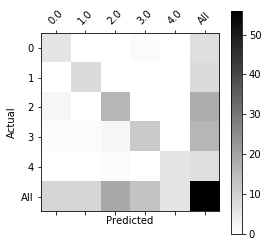

In [16]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## 2 - Emojifier-V2 : Using LSTMs in keras:


In [17]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### 2.1 - Overview of the model

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

### 2.2 - Keras and mini-batching

 If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 

### 2.3 - The Embedding Layer

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> **Figure 4**: Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional. </center></caption>

Implement the function below to convert X (array of sentences as strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 

In [18]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):
        sentence_i_words = X[i].lower().split()
        
        j = 0 
        for w in sentence_i_words:
            X_indices[i,j] = word_to_index[w]
            j = j + 1
    
    return X_indices

In [19]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


Implement `pretrained_embedding_layer()`. You will need to carry out the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [20]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1 # +1 to fill keras requiremnet
    emb_dim = word_to_vec_map["cucumber"].shape[0] #shape of e
    
    #step 1
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    #step 2
    for word,index in word_to_index.items():
        emb_matrix[index,:] = word_to_vec_map[word]
    
    #step 3
    embedding_layer = Embedding( vocab_len , emb_dim , trainable=False )
    embedding_layer.build((None,))
    
    #step 4
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [21]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


### 2.3 - Building the Emojifier - V2

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption>

Implement `Emojify_V2()`, which builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 5`). You may need `Input(shape = ..., dtype = '...')`, [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), and [Activation()](https://keras.io/activations/).

In [28]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    #define input to graph
    sentence_indices = Input(shape=input_shape,dtype='int32')
    
    #create embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    #propagate sentence through embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    #propagate embeddings through LSTM and return_sequence = True because you want op at each sequence state
    X = LSTM(128, return_sequences=True)(embeddings)
    
    #propagate sequence generated in above through dropouts
    X = Dropout(0.5)(X)
    
    #propagate sequence generated in above throught LSTM where one common output will be generated
    X = LSTM(128)(X)
    
    #This output is fed to dropout
    X = Dropout(0.5)(X)
    
    #Dense this output to represent 5 classes for emojis
    X = Dense(5,)(X)
    
    #applying softmax
    X = Activation('softmax')(X)
    
    #create model
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [29]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
__________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [30]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [31]:
X_train_indices = sentences_to_indices(X_train , word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train , C = 5)

In [32]:
model.fit(X_train_indices, Y_train_oh , epochs = 50 , batch_size = 32 , shuffle = True)

Epoch 1/50
132/132 [==============================] - 3s 24ms/step - loss: 1.5890 - acc: 0.2652
Epoch 2/50
132/132 [==============================] - 0s 2ms/step - loss: 1.5390 - acc: 0.3030
Epoch 3/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4704 - acc: 0.3712
Epoch 4/50
132/132 [==============================] - 0s 2ms/step - loss: 1.4399 - acc: 0.3939
Epoch 5/50
132/132 [==============================] - 0s 2ms/step - loss: 1.3696 - acc: 0.4773
Epoch 6/50
132/132 [==============================] - 0s 1ms/step - loss: 1.2215 - acc: 0.5227
Epoch 7/50
132/132 [==============================] - 0s 1ms/step - loss: 1.1347 - acc: 0.5379
Epoch 8/50
132/132 [==============================] - 0s 2ms/step - loss: 0.9987 - acc: 0.6136
Epoch 9/50
132/132 [==============================] - 0s 2ms/step - loss: 0.9660 - acc: 0.6667
Epoch 10/50
132/132 [==============================] - 0s 2ms/step - loss: 0.7485 - acc: 0.7500
Epoch 11/50
132/132 [===========================

In [38]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 7ms/step

Test accuracy =  0.8928571513720921


In [39]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞
